In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def binning(x,y,nbin=10,eq = True):
    step = (np.max(x)-np.min(x))/(nbin)
    X = []
    Y = []
    Yerr = []
    tmpY = []
    start = np.min(x)+step
    if eq:
        for i in range(len(x)):
            while x[i] > start:
                X.append(start-step/2)
                Y.append(np.mean(tmpY))
                #Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpY=[]
                pass
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(start-step/2)
            Y.append(np.mean(tmpY))
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X,Y,Yerr
        pass
    else:
        tmpX = []
        Xerr = []
        for i in range(len(x)):
            while x[i] > start:
                X.append(np.mean(tmpX))
                Y.append(np.mean(tmpY))
                Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpX=[]
                tmpY=[]
                pass
            tmpX.append(x[i])
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(np.mean(tmpX))
            Y.append(np.mean(tmpY))
            Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X, Y, Yerr

In [3]:
def PreProcessing(t,price):
    T = np.zeros(len(t))
    Price = np.zeros(len(t))
    prev = t[0]
    n = 0
    for i in range(len(t)):
        n += (prev != t[i])
        T[n] = t[i]
        Price[n] = price[i]
        prev = t[i]
        pass
    return T[:n+1],Price[:n+1]

In [4]:
INTC_LOB   = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]=="k"])
TSLA_LOB   = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]=="k"])
INTC_order = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]!="k"])
TSLA_order = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]!="k"])

## 2.2 Price flactuation and diffusion
``Here, the price $p_n$ is defined as the mid-point before n-th trade: $p_n:=m_{m^{-}}$''

In [52]:
def GetPriceBeforeTransaction(time, record, midprice):
    Mid = np.zeros(time.shape[0])
    prev = time[0]
    n = 0
    Mid[n] = prev
    for i,z,w in zip(midprice,record,time):
        n +=  ((z==4 or z==5) and prev != w)
        Mid[n] = i
        prev = w
        pass
    return Mid[:n]
    pass


In [119]:
TSLAPrice = []
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)[[0,1]]
    lob = pd.read_csv(z,header=None)[[0,2]]
    data[2] = (lob[0]+lob[2])/2
    a=GetPriceBeforeTransaction(data[0].values,data[1].values, data[2].values)
    TSLAPrice.extend(a.tolist().copy())
    pass
TSLAPrice = np.array(TSLAPrice)/10000

INTCPrice = []
for i,z in zip(INTC_order,INTC_LOB):
    data = pd.read_csv(i,header=None)[[0,1]]
    lob = pd.read_csv(z,header=None)[[0,2]]
    data[2] = (lob[0]+lob[2])/2
    a=GetPriceBeforeTransaction(data[0].values,data[1].values, data[2].values)
    INTCPrice.extend(a.tolist().copy())
    pass
INTCPrice = np.array(INTCPrice)/10000

In [120]:
r = [np.mean( (INTCPrice[i:]-INTCPrice[:-i])**2 )/i for i in range(1,10001)]
r1 = np.array(r)

In [121]:
r = [np.mean( (TSLAPrice[i:]-TSLAPrice[:-i])**2 )/i for i in range(1,10001)]
r2 = np.array(r)

In [122]:
np.min(np.sort(np.diff(np.sort(np.unique(INTCPrice))))),np.min(np.sort(np.diff(np.sort(np.unique(TSLAPrice)))))



(0.0049999999999954525, 0.0049999999999954525)

In [123]:
np.sqrt(r1[0]),np.sqrt(r2[0])

(0.006602386649134702, 0.0684439392454017)

### comment
We observed almost the same result as argued in the paper.

/home/kz-lab-admin/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kz-lab-admin/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kz-lab-admin/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kz-lab-admin/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


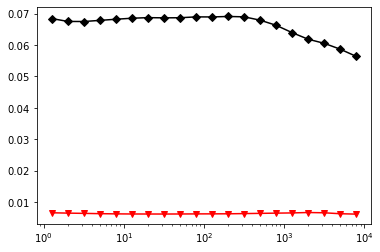

In [124]:

#plt.scatter(t[:10000], sq_r1/sq_r1[0])
x,y,yerr = binning(np.log10(t[:10000]),sq_r1,20)
plt.errorbar(10**np.array(x), y, yerr =yerr ,color="red",marker="v")
#plt.scatter(t[:10000], sq_r2/sq_r2[0])
x,y,yerr = binning(np.log10(t[:10000]),sq_r2,20)
plt.errorbar(10**np.array(x), y, yerr =yerr ,color="black",marker="D")

#plt.yscale("log")
plt.xscale("log")


## Response function and market impact
Response function of transaction can be defined as
$$
R(l) := \left\langle \left( p(l+t) -p(t)\right)\epsilon(t) \right\rangle
$$

In [199]:
def ResponseFunction(time, record, midprice, sign):
    Mid = np.zeros(time.shape[0])
    Sign = np.zeros(time.shape[0])
    prev = 0
    n = 0
    Mid[n] = midprice[n]
    for i,z,w,s in zip(midprice,record,time,sign):
        Sign[n] += s*((z==4 or z==5) and prev != w)
        n +=  ((z==4 or z==5) and prev != w)
        Mid[n] = i
        prev = w
        pass
    return Mid[:n],-Sign[:n]
    pass

In [200]:
TSLAPrice = []
TSLASign = []
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)[[0,1,5]]
    lob = pd.read_csv(z,header=None)[[0,2]]
    data[2] = (lob[0]+lob[2])/2
    a,b=ResponseFunction(data[0].values,data[1].values, data[2].values,data[5].values)
    TSLAPrice.extend(a.tolist().copy())
    TSLASign.extend(b.tolist().copy())
#    break
    pass
TSLAPrice = np.array(TSLAPrice)/10000
TSLASign = np.array(TSLASign)

In [201]:
r = [np.mean( (TSLAPrice[i:]-TSLAPrice[:-i])*TSLASign[:-i] ) for i in range(1,10001)]
r2 = np.array(r)
t = np.arange(1,10001,1)

/home/kz-lab-admin/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kz-lab-admin/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


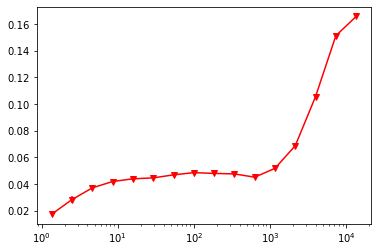

In [202]:

x,y,yerr = binning(np.log10(t),r2,15)
plt.errorbar(10**np.array(x), y, yerr =yerr ,color="red",marker="v")
plt.xscale("log")


In [203]:
TSLAPrice[0]

222.775

In [204]:
a[:100]

array([2038850., 2038850., 2038850., 2036500., 2036500., 2035100.,
       2037300., 2035100., 2037350., 2037350., 2037350., 2037350.,
       2037350., 2037350., 2037350., 2037350., 2037250., 2037450.,
       2037500., 2037450., 2037450., 2037350., 2037350., 2037400.,
       2036350., 2037400., 2036300., 2036300., 2037050., 2037050.,
       2037050., 2037050., 2037050., 2037200., 2037600., 2037600.,
       2037700., 2037700., 2036850., 2036850., 2036850., 2036850.,
       2036850., 2036850., 2036850., 2036350., 2036350., 2036300.,
       2034600., 2034600., 2034000., 2033900., 2033900., 2033900.,
       2033900., 2035200., 2035200., 2035200., 2035200., 2033650.,
       2033650., 2033650., 2033700., 2034250., 2037750., 2037750.,
       2039500., 2039500., 2039500., 2037750., 2037750., 2037750.,
       2038500., 2038600., 2038250., 2038200., 2034450., 2034450.,
       2034450., 2036050., 2036850., 2036850., 2037150., 2036150.,
       2036150., 2036150., 2036250., 2036250., 2036500., 20365

In [212]:
i = 128
a = (TSLAPrice[i:]-TSLAPrice[:-i])*TSLASign[:-i]


In [248]:
p1 = int(len(a[a>0])*0.01)
x = np.sort(a)[:-p1]
p1 = int(len(a[a>0])*0.01)
x = np.sort(a)[:-p1]

101866

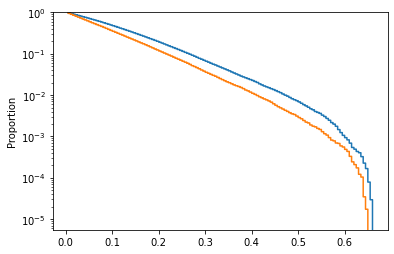

In [263]:
p1 = int(len(a[a>0])*0.002)
x = np.sort(a[a>0])[:-p1]
sns.ecdfplot(x,complementary=True)
p1 = int(len(a[a<0])*0.002)
x = np.sort(-a[a<0])[:-p1]
sns.ecdfplot(x,complementary=True)
plt.yscale("log")
#plt.xscale("log")
plt.show()


In [246]:
(-np.sort(a[a<0]))

array([1.8505e+01, 1.8450e+01, 1.8450e+01, ..., 5.0000e-03, 5.0000e-03,
       5.0000e-03])